<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Partie-1:-Régularisation-de-Tikhonov" data-toc-modified-id="Partie-1:-Régularisation-de-Tikhonov-1">Partie 1: Régularisation de Tikhonov</a></span></li><li><span><a href="#Partie-2:-Régularisation-pour-la-parcimoine" data-toc-modified-id="Partie-2:-Régularisation-pour-la-parcimoine-2">Partie 2: Régularisation pour la parcimoine</a></span></li><li><span><a href="#Partie-3:-Comparaison" data-toc-modified-id="Partie-3:-Comparaison-3">Partie 3: Comparaison</a></span></li></ul></div>

# SD211 TP2: Régression logistique
*<p>Author: Pengfei Mi</p>*
*<p>Date: 12/05/2017</p>*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cervicalcancerutils import load_cervical_cancer
from scipy.optimize import check_grad
from time import time
from sklearn.metrics import classification_report

## Partie 1: Régularisation de Tikhonov

$\textbf{Question 1.1}\quad\text{Calculer le gradient et la matrice hessienne.}$

<div class="alert alert-success">
    <p>
        Notons $\tilde{X} = (\tilde{\mathbf{x}}_1,...,\tilde{\mathbf{ x}}_n)^T$, où $\tilde{\mathbf{x}}_i = \begin{pmatrix}1\\ 
        \mathbf{x}_i\end{pmatrix}\in \mathbb{R}^{p+1}$, $\tilde{\mathbf{\omega}} = \begin{pmatrix}
        \omega_0\\\mathbf{\omega}\end{pmatrix}\in \mathbb{R}^{p+1}$, et la matrice
        $$A = diag(0,1,...,1) =
        \begin{pmatrix}
        0&0&\cdots&0\\
        0&1&&0\\
        \vdots&&\ddots&\vdots\\
        0&0&\cdots&1
        \end{pmatrix}
        $$
    </p>
    <p>
        On a:
        $$
        \begin{aligned}
        f_1(\omega_0, \omega) &= \frac{1}{n}\sum_{i=1}^{n}\text{log}\big(1+e^{-y_i(x_i^T\omega+\omega_0)}\big)+\frac{\rho}{2}\|\omega\|_2^2 \\
        & = \frac{1}{n}\sum_{i=1}^{n}\text{log}\big(1+e^{-y_i\tilde x_i^T \tilde \omega}\big)+\frac{\rho}{2}\tilde{\omega}^TA\tilde{\omega}
        \end{aligned}
        $$
    </p>
    <p>
        Ainsi on obtient le gradient:
        $$
        \begin{aligned}
        \nabla{f_1}(\omega_0, \omega) &= \frac{1}{n}\sum_{i=1}^{n}\frac{-e^{-y_i\tilde x_i^T \tilde \omega}y_i\tilde{\mathbf{x}}_i}{1+e^{-y_i\tilde x_i^T \tilde \omega}} + \rho A\tilde{\mathbf{\omega}} \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{-y_i\tilde{\mathbf{x}}_i}{1+e^{y_i\tilde x_i^T \tilde \omega}} + 
        \rho A\tilde{\mathbf{\omega}}
        \end{aligned}
        $$
    </p>
    <p>
        et la matrice hessienne:
        $$
        \begin{aligned}
        \mathbf{H} = \nabla^2f_1(\omega_0, \omega) &= \frac{1}{n}\sum_{i=1}^{n}\frac{e^{y_i\tilde x_i^T \tilde \omega}(y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})^2} + \rho A \\
        & = \frac{1}{n}\sum_{i=1}^{n}\frac{(y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} + \rho A
        \end{aligned}
        $$
    </p>
</div>

<div class="alert alert-success">
    <p>
        Soient $\omega \in \mathbb{R}^{p+1}$, on a:
        $$
        \begin{aligned}
        \omega^TH\omega &= \frac{1}{n}\sum_{i=1}^{n}\frac{\omega^T (y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T \omega}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} + \rho \omega^T A \omega \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{(\omega^T y_i\tilde{\mathbf{x}}_i)(\omega^T y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} + \rho \omega^T A^2 \omega \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{\|\omega^T y_i\tilde{\mathbf{x}}_i\|_2^2}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} + \rho \|A\omega\|_2^2 \geq 0
        \end{aligned}
        $$
    </p>
    <p>Donc, la matrice hessienne est semi-définie positive, la fonction $f_1$ est convexe.</p>
</div>

$\textbf{Question 1.2}\quad\text{Coder une fonction qui retourne la valeur de la fonction, son gradient et sa hessienne.}$

<div class="alert alert-success">
    <p>On insère une colonne de $1$ à gauche de $X$ pour simplifier le calcul.</p>
</div>

In [2]:
X, y = load_cervical_cancer("riskfactorscervicalcancer.csv")
print "Before the insertion:"
print X.shape, y.shape
n, p = X.shape
X = np.c_[np.ones(n), X]
print "After the insertion:"
print X.shape, y.shape

Before the insertion:
(210, 26) (210,)
After the insertion:
(210, 27) (210,)


In [3]:
def objective(w_, X, y, rho, return_grad=True, return_H=True):
    """
    X: matrix of size n*(p+1)
    y: vector of size n
    w0: real number
    w: vector of size p
    """
    # Initialize elementary intermediate variables;
    n, p = X.shape
    w = w_[1:]
    y_x = np.array([y[i] * X[i, :] for i in range(n)])
    yx_w = np.array([np.sum(y_x[i, :]*w_) for i in range(n)])
    exp_yxw_1 = np.array([np.exp(yx_w[i]) for i in range(n)]) + 1
    exp_neg_yxw_1 = np.array([np.exp(-yx_w[i]) for i in range(n)]) + 1
    
    # Compute function value
    val = np.mean(np.log(exp_neg_yxw_1)) + np.sum(w**2)*rho/2.
    
    if return_grad == False:
        return val
    else:
        # Compute gradient
        grad = np.mean(-np.array([y_x[i]/exp_yxw_1[i] for i in range(n)]), axis=0) + rho*np.r_[0, w]
        
        if return_H == False:
            return val, grad
        else:
            # Compute the Hessian matrix
            H = np.mean(np.array([y_x[i].reshape(-1, 1).dot(y_x[i].reshape(1, -1) / (exp_yxw_1[i]*exp_neg_yxw_1[i])) for i in range(n)]), axis=0) + rho*np.diag(np.r_[0, np.ones(p-1)])
            return val, grad, H

In [4]:
def funcMask(w_, X, y, rho):
    val, grad = objective(w_, X, y, rho, return_H=False)
    return val

def gradMask(w_, X, y, rho):
    val, grad = objective(w_, X, y, rho, return_H=False)
    return grad

rho = 1./n
t0 = time()
print "The difference of gradient is: %0.12f" % check_grad(funcMask, gradMask, np.zeros(p+1), X, y, rho)
print "Done in %0.3fs." % (time()-t0)

The difference of gradient is: 0.000000039161
Done in 0.073s.


In [5]:
def gradMask(w_, X, y, rho):
    val, grad = objective(w_, X, y, rho, return_H=False)
    return grad.sum()

def hessianMask(w_, X, y, rho):
    val, grad, H = objective(w_, X, y, rho)
    return np.sum(H, axis=1)

t0 = time()
rho = 1./n
print "The difference of Hessian matrix is: %0.12f" % check_grad(gradMask, hessianMask, np.zeros(p+1), X, y, rho)
print "Done in %0.3fs." % (time()-t0)

The difference of Hessian matrix is: 0.000000758053
Done in 0.079s.


<div class="alert alert-success">
    <p>On a vérifié le calcul de gradient et de matrice hessienne.</p>
</div>

$\textbf{Question 1.3}\quad\text{Coder la méthode de Newton.}$

<div class="alert alert-success">
    <p>
        Selon la définition de méthode de Newton, on a:
        $$\omega^{k+1} = \omega^k - (\nabla^2f_1(\omega^k))^{-1}\nabla f_1(\omega^k)$$
    </p>
</div>

In [6]:
def minimize_Newton(func, w_, X, y, rho, tol=1e-10):
    n, p = X.shape
    val, grad, H = func(w_, X, y, rho)
    grad_norm = np.sqrt(np.sum(grad**2))
    norms = [grad_norm]
    cnt = 0
    while (grad_norm > tol):
        w_ = w_ - np.linalg.solve(H, np.identity(p)).dot(grad)
        val, grad, H = func(w_, X, y, rho)
        grad_norm = np.sqrt(np.sum(grad**2))
        norms.append(grad_norm)
        cnt = cnt + 1
    return val, w_, cnt, norms

t0 = time()
rho = 1./n
val, w, cnt, grad_norms  = minimize_Newton(objective, np.zeros(p+1), X, y, rho, tol=1e-10)
print "The value minimal of the objective function is: %0.12f" % val
print "Done in %0.3fs, number of iterations: %d" % (time()-t0, cnt)
print w

The value minimal of the objective function is: 0.564490766022
Done in 0.043s, number of iterations: 7
[ 0.2013495  -0.17213872 -0.04798368 -0.14852973  0.17226181 -0.00720006
  0.20673756 -0.03692106  0.0768277   0.43086559  0.12956021  0.17260728
  0.31592059  0.17684201  0.10474188  0.10474188 -0.39105042  0.1639398
  0.66262584 -0.33199982  0.64063084 -0.39451384 -0.39515206  0.3884854
  0.02848865  0.3884854   0.27776305]


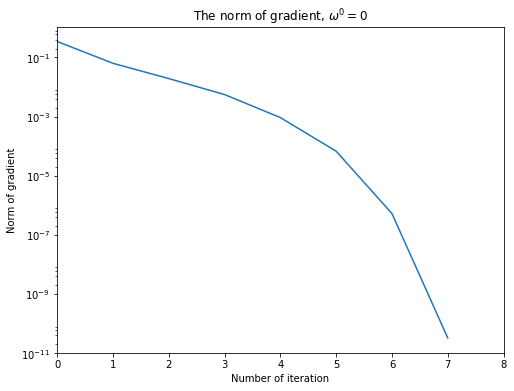

In [7]:
plt.figure(1, figsize=(8,6))
plt.title("The norm of gradient, $\omega^0 = 0$")
plt.semilogy(range(0, len(grad_norms)), grad_norms)
plt.xlabel("Number of iteration")
plt.ylabel("Norm of gradient")
plt.xlim(0, len(grad_norms))
plt.show()

$\textbf{Question 1.4}\quad\text{Lancer avec comme condition initiale }(\omega_0^0,\omega^0) = 0.3e\text{, où }e_i=0\text{ pour tout }i.$

In [8]:
t0 = time()
val, grad, H, cnt, grad_norms  = minimize_Newton(objective, 0.3*np.ones(p+1), X, y, rho, tol=1e-10)
print "The value minimal of the objective function is: %0.12f" % val
print "Done in %0.3fs, number of iterations: %d" % (time()-t0, cnt)

/Applications/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: overflow encountered in exp
/Applications/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: overflow encountered in exp


LinAlgError: Singular matrix

<div class="alert alert-success">
    <p>On a vu que avec cette condition initiale, la fonction objectif ne converge pas. C'est à cause de le point initiale est hors le domaine de convergence.</p>
</div>

$\textbf{Question 1.5}\quad\text{Coder la méthode de recherche linéaire d'Armijo.}$

<div class="alert alert-success">
    <p>Notons $\omega^+(\gamma_k)=\omega^k - \gamma_k(\nabla^2 f_1(\omega^k))^{-1}\nabla f_1(\omega^k)$, soient $a \in (0,1)$, $b>0$ et $\beta \in (0,1)$, on cherche le premier entier $l$ non-négatif tel que:</p>
    $$f_1(\omega^+(ba^l)) \leq f_1(\omega^k) + \beta\langle\nabla_{f_1}(\omega^k),\,\omega^+(ba^l)-\omega^k\rangle$$
</div>

<div class="alert alert-success">
    <p>Ici, on prend $\beta = 0.5$, ainsi que la recherche linéaire d'Armijo devient équicalente à la recherche linéaire de Taylor.</p>
    <p> On fixe $b_0 = 1$ et $b_k = 2\gamma_{k-1}$, c'est un choix classique.</p>
    <p> On fixe $a = 0.5$, c'est pour faire un compromis entre la précision de recherche et la vitesse de convergence.</p>
</div>

In [9]:
def minimize_Newton_Armijo(func, w_, X, y, rho, a, b, beta, tol=1e-10, max_iter=500):
    n, p = X.shape
    val, grad, H = func(w_, X, y, rho)
    grad_norm = np.sqrt(np.sum(grad**2))
    norms = [grad_norm]
    d = np.linalg.solve(H, np.identity(p)).dot(grad)
    gamma = b / 2.
    cnt = 0
    while (grad_norm > tol and cnt < max_iter):
        gamma = 2*gamma
        val_ = func(w_ - gamma*d, X, y, rho, return_grad=False)
        while (val_ > val - beta*gamma*np.sum(d*grad)):
            gamma = gamma*a
            val_ = func(w_ - gamma*d, X, y, rho, return_grad=False)
        w_ = w_ - gamma*d
        val, grad, H = func(w_, X, y, rho)
        d = np.linalg.solve(H, np.identity(p)).dot(grad)
        grad_norm = np.sqrt(np.sum(grad**2))
        norms.append(grad_norm)
        cnt = cnt + 1
    return val, w_, cnt, norms

t0 = time()
rho = 1./n
a = 0.5
b = 1
beta = 0.5
val_nls, w_nls, cnt_nls, grad_norms_nls  = minimize_Newton_Armijo(objective, 0.3*np.ones(p+1), X, y, rho, a, b, beta, tol=1e-10, max_iter=500)
print "The value minimal of the objective function is: %0.12f" % val_nls
t_nls = time()-t0
print "Done in %0.3fs, number of iterations: %d" % (t_nls, cnt_nls)
print w_nls

The value minimal of the objective function is: 0.564490766022
Done in 0.082s, number of iterations: 9
[ 0.2013495  -0.17213872 -0.04798368 -0.14852973  0.17226181 -0.00720006
  0.20673756 -0.03692106  0.0768277   0.43086559  0.12956021  0.17260728
  0.31592059  0.17684201  0.10474188  0.10474188 -0.39105042  0.1639398
  0.66262584 -0.33199982  0.64063084 -0.39451384 -0.39515206  0.3884854
  0.02848865  0.3884854   0.27776305]


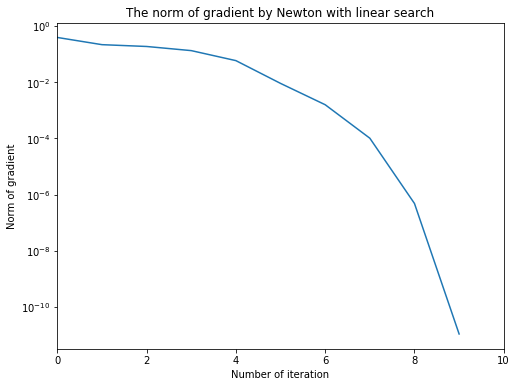

In [10]:
plt.figure(2, figsize=(8,6))
plt.title("The norm of gradient by Newton with linear search")
plt.semilogy(range(0, len(grad_norms_nls)), grad_norms_nls)
plt.xlabel("Number of iteration")
plt.ylabel("Norm of gradient")
plt.xlim(0, len(grad_norms_nls))
plt.show()

## Partie 2: Régularisation pour la parcimoine

$\textbf{Question 2.1}\quad\text{Pourquoi ne peut-on pas utiliser la méthode de Newton pour résoudre ce problème?}$

<div class="alert alert-success">
    <p>Parce que la fonction objectif ici n'est pas différentiable, on ne peut pas utiliser le gradient et la matrice hessienne.</p>
</div>

$\textbf{Question 2.2}\quad\text{Écrire la fonction objectif sous la forme }F_2 = f_2 + g_2\text{ où }f_2\text{ est dérivable et l’opérateur proximal de }g_2\text{ est simple.}$

<div class="alert alert-success">
    <p>
        $$
        \begin{aligned}
        F_2(\omega_0,\omega) &= \frac{1}{n}\sum_{i=1}^{n}\text{log}\big(1+e^{-y_i(x_i^T\omega+\omega_0)}\big)+\rho\|\omega\|_1 \\
        &= f_2+g_2
        \end{aligned}
        $$
        où $f_2 = \frac{1}{n}\sum_{i=1}^{n}\text{log}\big(1+e^{-y_i(x_i^T\omega+\omega_0)}\big)$ est dérivable, $g_2 = \rho\|\omega\|_1$ de laquelle l'opérateur proximal est simple.
    </p>
</div>

<div class="alert alert-success">
    <p>
        On a le gradient de $f_2$:
        $$
        \begin{aligned}
        \nabla{f_2}(\omega_0, \omega) &= \frac{1}{n}\sum_{i=1}^{n}\frac{-e^{-y_i\tilde x_i^T \tilde \omega}y_i\tilde{\mathbf{x}}_i}{1+e^{-y_i\tilde x_i^T \tilde \omega}} \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{-y_i\tilde{\mathbf{x}}_i}{1+e^{y_i\tilde x_i^T \tilde \omega}}
        \end{aligned}
        $$
    </p>
    <p>
        et l'opérateur proximal de $g_2$:
        $$
        \begin{aligned}
        \text{prox}_{g_2}(x) &= \text{arg}\,\underset{y \in \mathbb{R}^p}{\text{min}}\, \big(g_2(y) + \frac{1}{2}\|y-x\|^2 \big) \\
        &= \text{arg}\,\underset{y \in \mathbb{R}^p}{\text{min}}\, \big(\rho\|y\|_1 + \frac{1}{2}\|y-x\|^2 \big) \\
        &= \text{arg}\,\underset{y \in \mathbb{R}^p}{\text{min}}\, \sum_{i=1}^{p}\big(\rho |y_i| + \frac{1}{2}(y_i-x_i)^2\big)
        \end{aligned}
        $$
    </p>
    <p>
    pour $1 \leq i \leq n$, on obtient la solution:
    $$
    y_i^* = \left\{
    \begin{align}
    x_i - \rho, &\text{ si } x_i > \rho \\
    x_i + \rho, &\text{ si } x_i < -\rho \\
    0, &\text{ si } -\rho \leq x_i \leq \rho
    \end{align}
    \right.
    $$
    </p>
</div>

<div class="alert alert-success">
    <p>
        $$
        \begin{aligned}
        \mathbf{H_2} = \nabla^2f_2(\omega_0, \omega) &= \frac{1}{n}\sum_{i=1}^{n}\frac{e^{y_i\tilde x_i^T \tilde \omega}(y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})^2} \\
        & = \frac{1}{n}\sum_{i=1}^{n}\frac{(y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})}
        \end{aligned}
        $$
    </p>
    <p>
    Soient $\omega \in \mathbb{R}^{p+1}$, on a:
        $$
        \begin{aligned}
        \omega^TH_2\omega &= \frac{1}{n}\sum_{i=1}^{n}\frac{\omega^T (y_i\tilde{\mathbf{x}}_i)(y_i\tilde{\mathbf{x}}_i)^T \omega}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{(\omega^T y_i\tilde{\mathbf{x}}_i)(\omega^T y_i\tilde{\mathbf{x}}_i)^T}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{\|\omega^T y_i\tilde{\mathbf{x}}_i\|_2^2}{(1+e^{y_i\tilde x_i^T \tilde \omega})(1+e^{-y_i\tilde x_i^T \tilde \omega})} \geq 0
        \end{aligned}
        $$
    </p>
    <p>Donc, la matrice hessienne de $f_2$ est semi-définie positive, la fonction $f_2$ est convexe.</p>
    <p>
    $$
        \begin{aligned}
        g_2(\omega_0, \omega) &= \rho\|\omega\|_1 \\
        &= \rho \sum_{i=1}^{n}|\omega_i|
        \end{aligned}
    $$
    </p>
    <p>La fonction de valeur absolue est convexe pour chaque élément de $\omega$, pour $\rho \geq 0$, $g_2$ est aussi convexe.</p>
    <p>Donc $F_2 = f_2 + g_2$ est convexe pour $\rho \geq 0$.</p>
</div>

$\textbf{Question 2.3}\quad\text{Coder le gradient proximal avec recherche linéaire.}$

<div class="alert alert-success">
    <p>On rajoute la recherche linéaire de Taylor.</p>
    <p>On prend $a = 0.5$, $b_0 = 1b$ et $b = 2\gamma_{k-1}$. On cherche le premier entier $l$ non-négatif tel que:</p>
    $$f_2(\omega^+(ba^l)) \leq f_2(\omega^k) + \langle\nabla_{f_2}(\omega^k),\,\omega^+(ba^l)-\omega^k\rangle + \frac{1}{2ba^l}\|\omega^k - \omega^+(ba^l)\|^2$$
</div>

<div class="alert alert-success">
    On peut utiliser un seuillage pour la valeur de fonction objectif évaluée dans une itération comme test d'arrêt.
</div>

In [11]:
def objective_proximal(w_, X, y, rho):
    """
    X: matrix of size n*(p+1)
    y: vector of size n
    w0: real number
    w: vector of size p
    """
    # Initialize elementary intermediate variables;
    n, p = X.shape
    w = w_[1:]
    y_x = np.array([y[i] * X[i, :] for i in range(n)])
    yx_w = np.array([np.sum(y_x[i, :]*w_) for i in range(n)])
    exp_neg_yxw_1 = np.array([np.exp(-yx_w[i]) for i in range(n)]) + 1
    
    # Compute function value
    val = np.mean(np.log(exp_neg_yxw_1)) + rho*np.sum(np.fabs(w)) 
    return val

def f(w_, X, y, return_grad=True):
    """
    X: matrix of size n*(p+1)
    y: vector of size n
    w0: real number
    w: vector of size p
    """
    # Initialize elementary intermediate variables;
    n, p = X.shape
    w = w_[1:]
    y_x = np.array([y[i] * X[i, :] for i in range(n)])
    yx_w = np.array([np.sum(y_x[i, :]*w_) for i in range(n)])
    exp_yxw_1 = np.array([np.exp(yx_w[i]) for i in range(n)]) + 1
    exp_neg_yxw_1 = np.array([np.exp(-yx_w[i]) for i in range(n)]) + 1
    
    # Compute function value
    val = np.mean(np.log(exp_neg_yxw_1))
    
    if return_grad == False:
        return val
    else:
        # Compute gradient
        grad = np.mean(-np.array([y_x[i]/exp_yxw_1[i] for i in range(n)]), axis=0)
        return val, grad
    
def Soft_Threshold(w, rho):
    w_ = np.zeros_like(w)
    w_[w > rho] = w[w > rho] - rho
    w_[w < -rho] = w[w < -rho] + rho
    w_[0] = w[0]
    return w_

def minimize_prox_grad_Taylor(func, f, w_, X, y, rho, a, b, tol=1e-10, max_iter=500):
    n, p = X.shape
    val = func(w_, X, y, rho)
    val_f, grad_f = f(w_, X, y)
    gamma = b / 2.
    delta_val = tol*2
    cnt = 0
    while (delta_val > tol and cnt < max_iter):
        gamma = 2*gamma
        w_new = Soft_Threshold(w_ - gamma*grad_f, gamma*rho)
        val_f_ = f(w_new, X, y, return_grad=False)
        #while (val_f_ > val_f + beta*np.sum(grad_f*(w_new - w_))):
        while (val_f_ > val_f + np.sum(grad_f*(w_new-w_)) + np.sum((w_new-w_)**2)/gamma):
            #print val_
            gamma = gamma*a
            w_new = Soft_Threshold(w_ - gamma*grad_f, gamma*rho)
            val_f_ = f(w_new, X, y, return_grad=False)
        w_ = w_new
        val_f, grad_f = f(w_, X, y)
        val_ = func(w_, X, y, rho)
        delta_val = val - val_
        val = val_
        cnt = cnt + 1
    return func(w_, X, y, rho), w_, cnt

t0 = time()
rho = 0.1
a = 0.5
b = 1
val_pgls, w_pgls, cnt_pgls  = minimize_prox_grad_Taylor(objective_proximal, f, 0.3*np.ones(p+1), X, y, rho, a, b, tol=1e-8, max_iter=500)
print "The value minimal of the objective function is: %0.12f" % val_pgls
t_pgls = time()-t0
print "Done in %0.3fs, number of iterations: %d" % (t_pgls, cnt_pgls)
print w_pgls

The value minimal of the objective function is: 0.692565193505
Done in 0.072s, number of iterations: 8
[-0.05716261  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.004657
  0.          0.          0.          0.          0.          0.
  0.00538332  0.          0.          0.01859929  0.          0.01859929
  0.        ]


In [29]:
def objective_proximal(w_, X, y, rho, return_grad=True):
    """
    X: matrix of size n*(p+1)
    y: vector of size n
    w0: real number
    w: vector of size p
    """
    # Initialize elementary intermediate variables;
    n, p = X.shape
    w = w_[1:]
    y_x = np.array([y[i] * X[i, :] for i in range(n)])
    yx_w = np.array([np.sum(y_x[i, :]*w_) for i in range(n)])
    exp_yxw_1 = np.array([np.exp(yx_w[i]) for i in range(n)]) + 1
    exp_neg_yxw_1 = np.array([np.exp(-yx_w[i]) for i in range(n)]) + 1
    
    # Compute function value
    val = np.mean(np.log(exp_neg_yxw_1)) + rho*np.sum(np.fabs(w)) 
    
    if return_grad == False:
        return val
    else:
        # Compute gradient
        grad = np.mean(-np.array([y_x[i]/exp_yxw_1[i] for i in range(n)]), axis=0)
        return val, grad
    
def Soft_Threshold(w, rho):
    w_ = np.zeros_like(w)
    w_[w > rho] = w[w > rho] - rho
    w_[w < -rho] = w[w < -rho] + rho
    w_[0] = w[0]
    return w_

def minimize_prox_grad_Armijo(func, w_, X, y, rho, a, b, beta, tol=1e-10, max_iter=500):
    val, grad = func(w_, X, y, rho)
    gamma = b / 2.
    delta_val = tol*2
    cnt = 0
    while (delta_val > tol and cnt < max_iter):
        gamma = 2*gamma
        w_new = Soft_Threshold(w_ - gamma*grad, rho)
        val_ = func(w_new, X, y, rho, return_grad=False)
        while (val_ > val + beta*np.sum(grad*(w_new - w_))):
            gamma = gamma*a
            w_new = Soft_Threshold(w_ - gamma*grad, rho)
            val_ = func(w_new, X, y, rho, return_grad=False)
        w_ = w_new
        val_, grad = func(w_, X, y, rho)
        delta_val = val - val_
        val = val_
        cnt = cnt + 1
    return val, w_, cnt

t0 = time()
rho = 0.1
a = 0.7
b = 1
beta = 0.5
val_pgls, w_pgls, cnt_pgls  = minimize_prox_grad_Armijo(objective_proximal, 0.3*np.ones(p+1), X, y, rho, a, b, beta, tol=1e-6, max_iter=500)
print "The value minimal of the objective function is: %0.12f" % val_pgls
t_pgls = time()-t0
print "Done in %0.3fs, number of iterations: %d" % (t_pgls, cnt_pgls)
print w_pgls

The value minimal of the objective function is: 0.692577339566
Done in 0.178s, number of iterations: 21
[-0.0567545   0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.01092454  0.          0.          0.0130465   0.          0.0130465   0.        ]


## Partie 3: Comparaison

$\textbf{Question 3.1}\quad\text{Comparer les propriétés des deux problèmes d’optimisation.}$

<div class="alert alert-success">
    <p>1. Toutes les deux fonctions objectifs sont convexes, laquelle de régularisation de Tikhonov est différentible, l'autre n'est pas différentiable.</p>
    <p>2. Selon les deux $\omega$ qu'on obtient, la régularisation de Tiknonov utilise tous les variables explicatives, la régularisation pour la parcimoine en utilise une partie.</p>
</div>

$\textbf{Question 3.2}\quad\text{Comparer les solutions obtenues avec les deux types de régularisation.}$

In [30]:
y_pred_nls = np.sign(X.dot(w_nls))
y_pred_pgls = np.sign(X.dot(w_pgls))
print "The chance level is: %f" % max(np.mean(y == 1), 1-np.mean(y == 1))
print "The score by Newton method with line search is: %f" % np.mean(y == y_pred_nls)
print "The score by proximal gradient method with line search is: %f" % np.mean(y == y_pred_pgls)

print "-"*60
print "Classification report for Newton method"
print classification_report(y, y_pred_nls)
print "-"*60
print "Classification report for proximal gradient method"
print classification_report(y, y_pred_pgls)

The chance level is: 0.514286
The score by Newton method with line search is: 0.685714
The score by proximal gradient method with line search is: 0.561905
------------------------------------------------------------
Classification report for Newton method
             precision    recall  f1-score   support

       -1.0       0.65      0.84      0.73       108
        1.0       0.76      0.52      0.62       102

avg / total       0.70      0.69      0.68       210

------------------------------------------------------------
Classification report for proximal gradient method
             precision    recall  f1-score   support

       -1.0       0.54      1.00      0.70       108
        1.0       1.00      0.10      0.18       102

avg / total       0.76      0.56      0.45       210



<div class="alert alert-success">
    <p>En comparant les scores et les rapports de classification:</p>
    <p>1. Le score obtenu par la méthode de Newton est meilleur que celui de la méthode de gradient proximal.</p>
    <p>2. Selon le f1-score, la méthode de Newton est aussi meilleur.</p>
    <p>3. Dans la méthode de gradient proximal, la «precision» pour class 1 est 1.0, de plus, la «recall» est 0.1. On peut conclure que cette méthode avandage la class 1.</p>
</div>